In [1]:
 import numpy as np

def bin2mat_transform(bin_file,shape_h=1024,order='F'):
    '''
    将bin文件转成numpy矩阵形式
    RadarViewer输出的bin order是F
    python numpy tofile输出的bin order是C（此条不确定）
    '''
   
    assert bin_file.suffix == '.bin'
    data = np.fromfile(str(bin_file),dtype=np.float64)
    data = data.reshape(shape_h, int(len(data)/shape_h), order=order)
    data = data[:, :5000]
    return data.T

def list2numpy(data, dataType='byte'):
    import numpy as np
    if dataType == 'byte':
        dataTrans = []
        for ele in data:
            dataTrans.append(byte2signedInt(ele))
        arr = np.asarray(dataTrans)
    else:
        arr = np.asarray(data)
    return arr

In [2]:
def bin2mat(bin_file,shape_h=1024,order='F'):
    '''
    将bin文件转成numpy矩阵形式
    RadarViewer输出的bin order是F
    python numpy tofile输出的bin order是C（此条不确定）
    '''
    import numpy as np

    assert bin_file.suffix == '.bin'
    data = np.fromfile(str(bin_file),dtype=np.float64).reshape(shape_h,-1,order=order)
    data = data[:,:5000]
    return data

In [17]:
import os
from pathlib2 import Path, PureWindowsPath
os.chdir('F:/20201219_GPS/500M/')
datapath = Path(PureWindowsPath(r'F:/20201219_GPS/500M/CAS_S500Y_5.bin'))
origin = bin2mat(datapath)
mock = bin2mat_transform(datapath)
mock = mock.T.tolist()

In [41]:
mock.T.shape

(5000, 1024)

In [44]:
len(mock[0])

1024

In [61]:
# mock = mock.T.tolist()
cleanPlots = mock[0]
a = np.zeros((1024,))
reversePlots = np.expand_dims(np.asarray(cleanPlots).T, axis=1)
# a = np.expand_dims(np.asarray(a).T, axis=1)
# reversePlots = np.append(reversePlots, a, axis=1)
reversePlots.shape
(a == np.zeros((1024,))).all()

True

In [ ]:
singleWindowRadarData = mock[0:416]
mockWindow1 = list2numpy(singleWindowRadarData, dataType='array').reshape(1024, -1, order='F')
mockWindow1 = mockWindow1[111:111+416, :]
mockWindow1.shape

In [127]:
originWindow1 = origin[111:111+416, 0:416]
# originWindow1 = originWindow1[:, 0: 416]
print(originWindow1.shape)

(416, 416)


In [128]:
originWindow1 = np.fliplr(originWindow1)
mockWindow1 = np.fliplr(originWindow1)
(mockWindow1.T==originWindow1).all()

False

In [133]:
originWindow1

array([[ 2.1369e+04,  2.0892e+04,  2.0788e+04, ...,  2.9234e+04,
         2.9328e+04,  2.9262e+04],
       [ 1.9808e+04,  1.9170e+04,  1.9222e+04, ...,  2.8700e+04,
         2.8744e+04,  2.8801e+04],
       [ 1.8048e+04,  1.7468e+04,  1.7665e+04, ...,  2.7739e+04,
         2.7728e+04,  2.7946e+04],
       ...,
       [ 1.1230e+03,  1.0660e+03,  1.0850e+03, ...,  4.8000e+01,
         1.4000e+01, -2.2000e+01],
       [ 1.0940e+03,  1.0210e+03,  1.0140e+03, ...,  6.2000e+01,
         3.0000e+01,  4.0000e+00],
       [ 1.0470e+03,  9.7700e+02,  9.5600e+02, ...,  7.2000e+01,
         4.0000e+01,  2.7000e+01]])

In [134]:
mockWindow1.T

array([[ 2.9262e+04,  2.8801e+04,  2.7946e+04, ..., -2.2000e+01,
         4.0000e+00,  2.7000e+01],
       [ 2.9328e+04,  2.8744e+04,  2.7728e+04, ...,  1.4000e+01,
         3.0000e+01,  4.0000e+01],
       [ 2.9234e+04,  2.8700e+04,  2.7739e+04, ...,  4.8000e+01,
         6.2000e+01,  7.2000e+01],
       ...,
       [ 2.0788e+04,  1.9222e+04,  1.7665e+04, ...,  1.0850e+03,
         1.0140e+03,  9.5600e+02],
       [ 2.0892e+04,  1.9170e+04,  1.7468e+04, ...,  1.0660e+03,
         1.0210e+03,  9.7700e+02],
       [ 2.1369e+04,  1.9808e+04,  1.8048e+04, ...,  1.1230e+03,
         1.0940e+03,  1.0470e+03]])

In [75]:
def GPRGPSReader(GPR_file, sample_point=1024):
    '''
    读取二进制文件.GPR中的GPS信息
    .GPR文件结构如下：
        文件头 1065字节
        每道道头 90字节
        每道数据 sample_point*2字节

    GPS信息位于第15字节

    输入GPR文件路径的str 或者 Path对象
    返回每一道GPS的X Y Z坐标
    '''
    import struct
    import matplotlib.pyplot as plt
    import numpy as np
    from pathlib2 import Path

    file = Path(GPR_file)

    dPosXYZs = []

    file_byte = file.stat().st_size
    file_info_byte = 1065
    trace_byte = 90 + sample_point*2
    trace_num = (file_byte -file_info_byte)/trace_byte

    assert (file_byte -file_info_byte) % trace_byte == 0 #不为0说明sample_point不对
    
    with open(file, 'rb') as f:
        # 整个数据开头有1065字节数据头 + 每道道头90 + 每道数据1024*2
        f.seek(file_info_byte) #跳过数据开头冗余的1065字节
        for trace_ii in np.arange(trace_num ):
            try:
                fGPSOffset = struct.unpack('f',f.read(4))[0]
                chReserve = struct.unpack('2c',f.read(1*2))
            except:
                print(trace_ii)
                break
            else:    
                ucYear = struct.unpack('B',f.read(1))[0]
                ucMonth = struct.unpack('B',f.read(1))[0]
                ucDay = struct.unpack('B',f.read(1))[0]
                ucHour = struct.unpack('B',f.read(1))[0]
                ucMin = struct.unpack('B',f.read(1))[0]
                ucSec = struct.unpack('B',f.read(1))[0]
                usMilSec = struct.unpack('H',f.read(2))[0]
                
    #            dPosX,dPosY,dPosZ = struct.unpack('3d',f.read(8*3))
                dPosXYZ = struct.unpack('3d',f.read(8*3))
                dPosXYZs.append(dPosXYZ)
            
                ucTrcCount = struct.unpack('BB',f.read(1*2))
                ucVoltage = struct.unpack('BB',f.read(1*2))
                
                fWheelOffset = struct.unpack('f',f.read(4))[0]
            
                chPhotoName1 = struct.unpack('8c',f.read(1*8))
                chPhotoName2 = struct.unpack('8c',f.read(1*8))
            
                usMetalDiameter = struct.unpack('H',f.read(2))[0]
                usMetalDepth = struct.unpack('H',f.read(2))[0]
                bMetalFlag = struct.unpack('?',f.read(1))[0]
            
                chMarkName = struct.unpack('17c',f.read(1*17))
                fMarkHeight = struct.unpack('f',f.read(4))[0]
                usMarkFlag = struct.unpack('H',f.read(2))[0]
                
                data = struct.unpack(str(sample_point)+'H',f.read(sample_point*2))

    dPosXYZs = np.array(dPosXYZs).T
    return dPosXYZs

In [78]:
file = Path(PureWindowsPath(r'F:/20201219_GPS/500M/CAS_S500Y_4.GPR'))
origin_GPS = GPRGPSReader(file)
origin_GPS = np.fliplr(origin_GPS)

In [92]:
a = np.zeros((2,))
b = np.zeros((2,))
a = np.expand_dims(a, axis=0)
c = np.append(a,a ,axis=0)
a = np.ones((2,))
c

array([[0., 0.],
       [0., 0.]])

In [1]:
def loadFile(filename=''):
    import pickle
    import numpy as np
    if not filename:
        filepath = respath.DEFAULT_DATA_NAME + '20201227.pkl'
    elif len(filename.split('/')) > 1:
        filepath = filename
        fileformat = filename.split('/')[-1].split('.')[1]
    else:
        fileformat = filename.split('.')[1]
        filepath = respath.DEFAULT_DATA_NAME + filename
    try:
        f = open(filepath, 'rb')
        if fileformat == 'pkl':
            return pickle.load(f)
        elif fileformat == 'npy':
            return np.load(f)
        else:
            return errorhandle.UNKNOW_FILE_FORMAT
    except IOError:
        return errorhandle.LOAD_FILE_IO_ERROR

In [36]:
windows = loadFile("F:/RadarCAS/data/2021_01_15_17_54_37_windows1.pkl")
radar = loadFile("F:/RadarCAS/data/2021_01_15_17_54_36_radar1.pkl")
# feats = loadFile("F:/RadarCAS/data/2021_01_11_16_38_17_feats1.pkl")
# rawRadar = loadFile("F:/RadarCAS/data/2021-01-09-17-21-50-raw1.pkl")

In [37]:
len(windows)
# rawRadar = np.asarray(rawRadar)
# rawRadar[0:416, 111:111+416]

10

In [10]:
(windows[0] == originWindow1).all()

NameError: name 'originWindow1' is not defined

In [38]:
len(windows[0])

416

In [18]:
origin[111:111+416, 0:416]

array([[28565., 28415., 28728., ..., 28116., 28627., 28376.],
       [27373., 27152., 27863., ..., 27057., 27768., 27390.],
       [25882., 25639., 26494., ..., 25695., 26560., 26097.],
       ...,
       [  102.,   113.,   127., ...,   155.,   188.,   180.],
       [   94.,   110.,   129., ...,   143.,   211.,   172.],
       [   88.,   109.,   137., ...,   136.,   232.,   169.]])

In [63]:
(windows[0] == windows[4]).all()

False

<IPython.core.display.Javascript object>


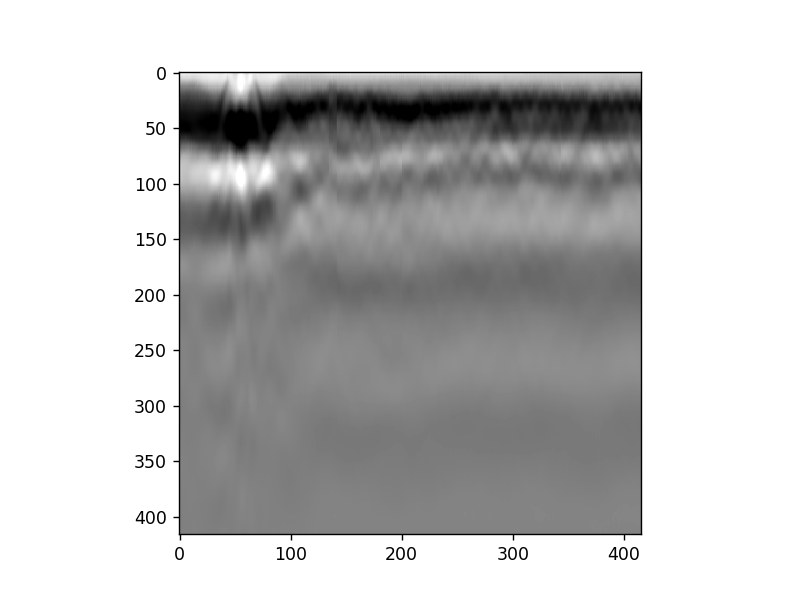

<IPython.core.display.Javascript object>


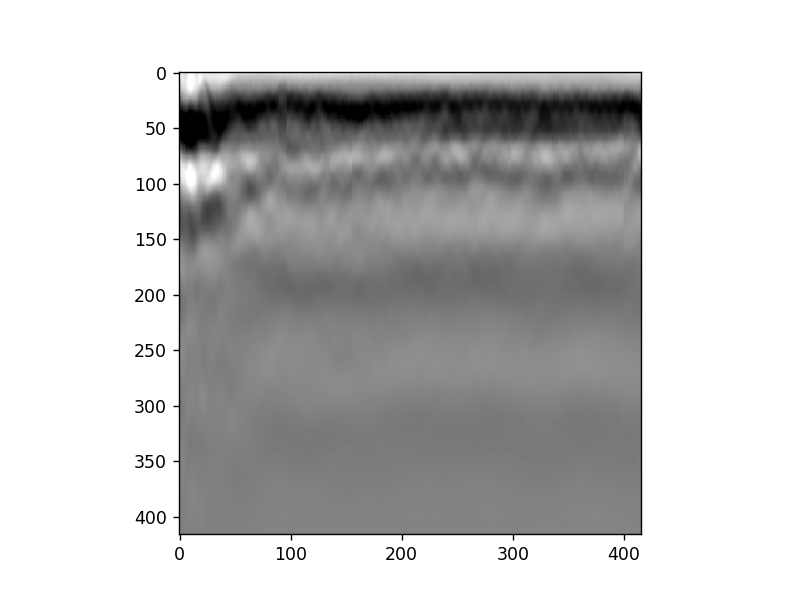

<IPython.core.display.Javascript object>


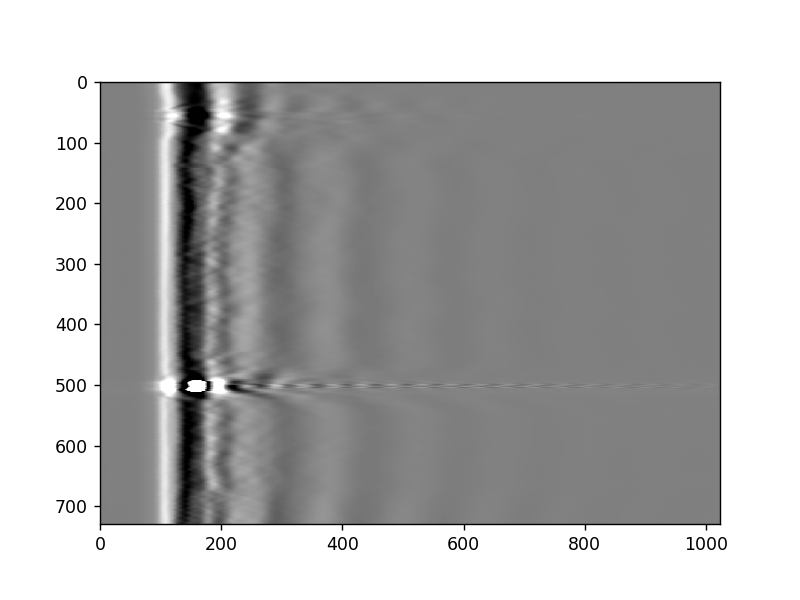

<IPython.core.display.Javascript object>


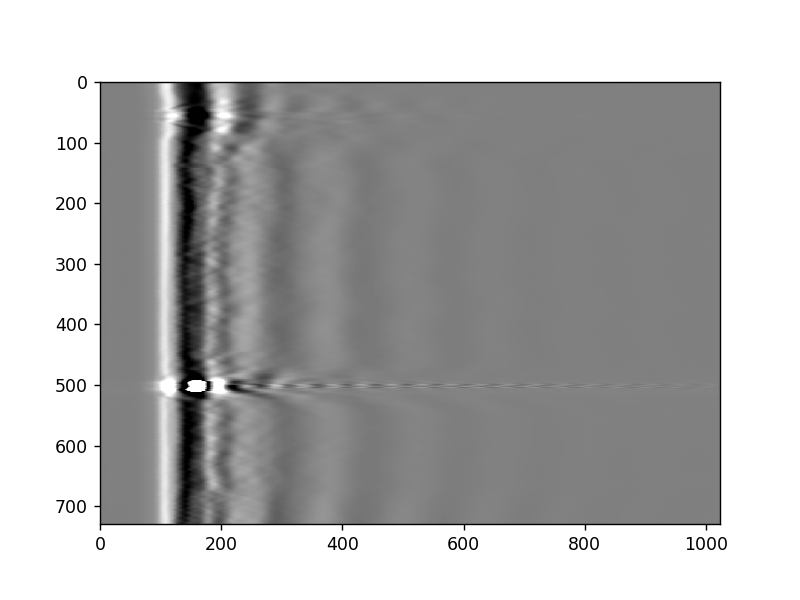

In [42]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(windows[0], cmap='gray')
plt.figure()
plt.imshow(windows[9], cmap='gray')
plt.figure()
plt.imshow(radar, cmap='gray')
plt.figure()
plt.imshow(radar, cmap='gray')
# plt.figure()
# plt.imshow(origin[111:111+416, 0:416], cmap='gray')
# plt.figure()
# plt.imshow(rawRadar.T, cmap='gray')

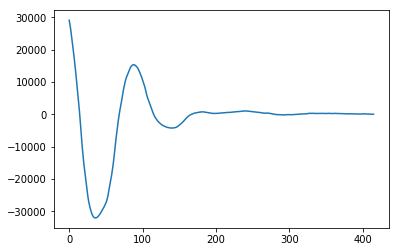

In [29]:
plt.figure()
plt.plot(windows[0][:,100])
plt.show()

In [70]:
import numpy as np
a = [1, 2, 3, 4, 5, 6, 7, 8]
a = np.asarray(a)
a = a.reshape((2, 4))
# np.fliplr(a)
a

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [75]:
b = a[:, -1]
b = np.tile(a[:, -1, np.newaxis], (1, 2))
c = np.hstack((a, b))
c

array([[1, 2, 3, 4, 4, 4],
       [5, 6, 7, 8, 8, 8]])

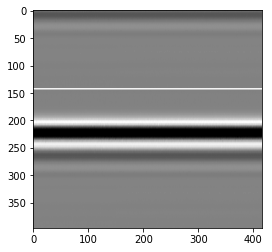

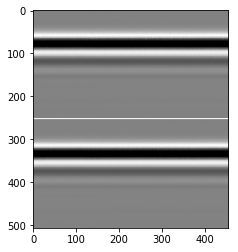

In [6]:
plt.figure()
plt.imshow(radar[111:111+416, 0:416], cmap='gray')
plt.figure()
plt.imshow(radar, cmap='gray')

In [9]:
originFeat

array([[0.        , 0.        , 0.        , ..., 0.07103514, 0.        ,
        0.        ]], dtype=float32)

In [34]:
gps = np.array(loadFile("F:/RadarCAS/data/2021_01_11_16_38_17_radar1.pkl"))
gps.shape

(1024, 1634)

In [69]:
import matplotlib.pyplot as plt
exceptData = loadFile("F:/RadarCAS/data/2021_01_14_11_02_42_debug.pkl")


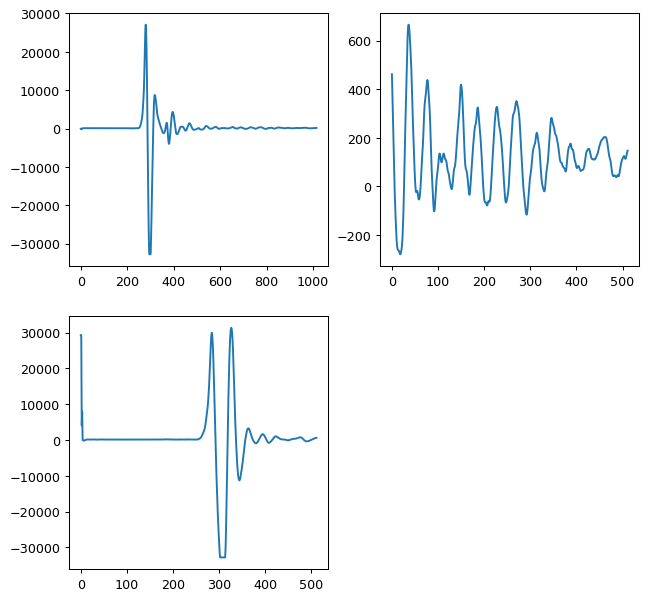

In [15]:
plt.figure(figsize=(8,8), dpi=92)
pc1 = plt.subplot(221)
pc1.plot(exceptData[0][4:] + exceptData[1][4:])
pc2 = plt.subplot(222)
pc2.plot(exceptData[1])
pc3 = plt.subplot(223)
pc3.plot(exceptData[2])
plt.show()

In [70]:
title = [29268, 29268, 4095]
exceptData.append([0]*1024) #3 error 
exceptData.append([29268, 29268, 4095, 7863, 5620]) #4 error
exceptData.append([0] * 507) #5 pass
exceptData.append([0] * 512) #6 error
exceptData.append(title + [0] * 509)#7pass
temp = [0] * 512 + title + [0] * 509
exceptData.append(temp) #8 pass

In [74]:
# buffer = []
print(len(exceptData))
for i,ele in enumerate(exceptData):
    title_index = search_radar_title(ele)
    print("index: " + str(i) + " | got title_index: " + str(title_index))
    process(title_index, ele)
    print("index: " + str(i) + "| current buffer length: " + str(len(buffer)) 
          + " | buffer is start with header: " + str(buffer[0:3] == title))
    

9
index: 0 | got title_index: 0
Unexcepted data length found, just ignore it..
index: 0| current buffer length: 512 | buffer is start with header: True
index: 1 | got title_index: -1
Plots length : 1024
index: 1| current buffer length: 0 | buffer is start with header: False
index: 2 | got title_index: 0
index: 2| current buffer length: 512 | buffer is start with header: True
index: 3 | got title_index: -1
Unexcepted data found: length is enough but no title found!
index: 3| current buffer length: 512 | buffer is start with header: True
index: 4 | got title_index: 0
Unexcepted data length found, just ignore it..
index: 4| current buffer length: 5 | buffer is start with header: True
index: 5 | got title_index: -1
index: 5| current buffer length: 512 | buffer is start with header: True
index: 6 | got title_index: -1
Plots length : 1024
index: 6| current buffer length: 0 | buffer is start with header: False
index: 7 | got title_index: 0
index: 7| current buffer length: 512 | buffer is star

In [73]:
def process(title_index, plots):
            global buffer
            plots = list(plots)
            if title_index == 0 and len(plots) == 1024:
                print("PASS")
            elif title_index == 0 and len(plots) < 1024:
                if len(buffer) != 0:
                    print("Unexcepted data length found, just ignore it..")
                buffer = plots
                return
            elif title_index != 0 and len(plots) == 1024:
                if title_index != -1:
                    if len(buffer) + title_index == 1024:
                        buffer.extend(plots[:title_index])
                        temp = buffer
                        buffer = plots[title_index:]
                        plots = temp
                    else:
                        print("Unexcepted data found, length is not enough..ignore it..")
                        buffer = plots[title_index:]
                        return
                else:
                    print("Unexcepted data found: length is enough but no title found!")
                    return
            elif title_index != 0 and len(plots) < 1024:
                if title_index != -1:
                    if len(buffer) + title_index == 1024:
                        buffer.extend(plots[:title_index])
                        temp = buffer
                        buffer = plots[title_index:]
                        plots = temp
                else:
                    if len(buffer) + len(plots) == 1024 and buffer[:3] == title:
                        buffer.extend(plots)
                        plots = buffer
                        buffer = []
                    elif len(buffer) + len(plots) < 1024 and buffer[:3] == title:
                        buffer.extend(plots)
                        return
                    elif buffer[:4] != title:
                        print("No title found in buffer head..Just cut it")
                        buffer = []
                    else:
                        print("Unexcepted data found: concat length is too long or no title in buffer..Just cut it")
                        buffer.extend(plots[:1024-len(buffer)])
            print("Plots length : " + str(len(plots)))
                        
def search_radar_title(aTuple):
    for index, ele in enumerate(aTuple):
        if ele == 29268 and aTuple[index+1] == 29268 and aTuple[index+2] == 4095:
            return index
    return -1

In [12]:
# PERFORMANCE ANALISING
# perfColRadar = "col Radar"
# perfColGPS = "col GPS"
# perfCal = "calcualte"
perf = loadFile("F:/RadarCAS/data/performance/perf3000_20Hz.pkl")

In [16]:
import numpy as np
def showPerf(perf):
    caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
    print("Length calculate time, colrtime, colgtime", end = ':')
    for ele in perf:
        print(len(perf[ele]), end=' | ')
    print()
    print("Max time: ")
    print(max(caltime), end='|')
    print(max(colrtime), end='|')
    print(max(colgtime))
    print("Mean time: ")
    print(np.mean(caltime), end='|')
    print(np.mean(colrtime), end='|')
    print(np.mean(colgtime))

In [17]:
caltime, colrtime, colgtime = perf["calcualte"], perf["col Radar"], perf["col GPS"]
showPerf(perf)
# print(max(caltime), end='|')
# print(max(colrtime), end='|')
# print(max(colgtime))

Length calculate time, colrtime, colgtime:3040 | 3040 | 3040 | 
Max time: 
0.0031837340734170994|1.5106364908148748|0.0010164698229004898
Mean time: 
0.00010671139952870454|0.052005731542433535|4.979047644234799e-05


<IPython.core.display.Javascript object>


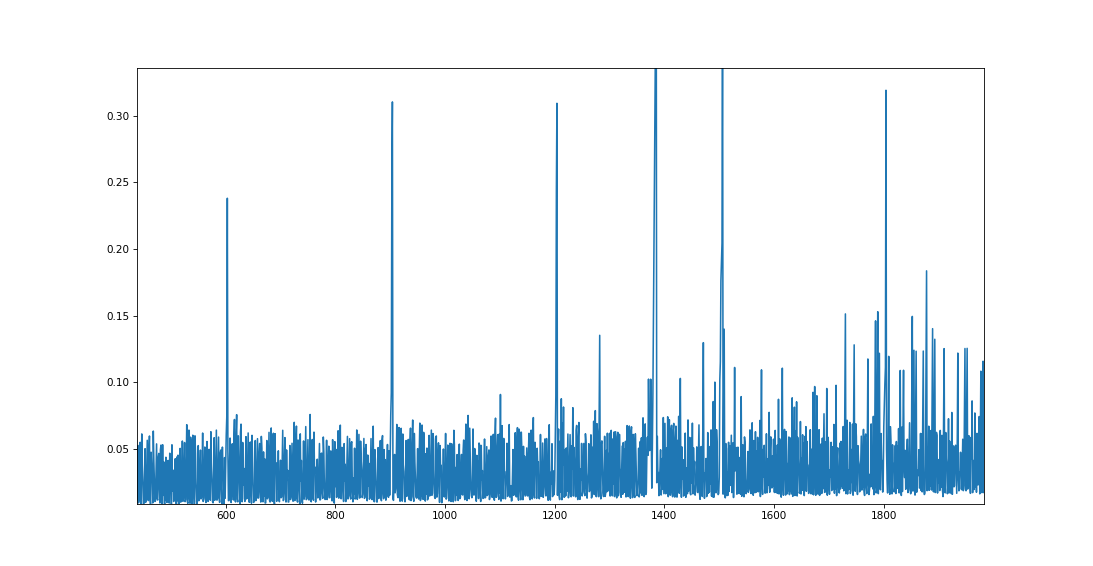

In [15]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
perf["calcualte"].extend([0]*(len(colrtime) - len(caltime)))

a = pd.DataFrame(perf)

plt.figure(figsize=(8,8), dpi=60)
plt.plot(a['col Radar'])
plt.show()

In [31]:
import time
a = []
start = time.clock()
for i in range(0, 70000):
    ele = [i for i in range(0, 1024)]
    a.append(ele)
print(time.clock() - start)
# start = time.clock()
# b = np.asarray(a[0:1024])
# print(time.clock() - start)

3.4659142280175104


In [33]:
for i in range(0, 100):
    start = time.clock()
    b = np.asarray(a[i:i+416]).T
    b = b[0:416,:]
    print(time.clock() - start)

0.018363016762009465
0.017576946765586854
0.017661276113869917
0.017567007949537583
0.017832043044109014
0.017559779719647395
0.01761188320989504
0.017567007949537583
0.017594414987740947
0.017597727926386142
0.017634772604424143
0.01772482430129685
0.017914264158662263
0.017633869075666553
0.017808852473365278
0.01791396298244763
0.017692598443204588
0.017710669017844793
0.017625737317075618
0.017760363098034304
0.01759501734022706
0.01773325723615926
0.01757875382304519
0.017758857216847446
0.01761007615237986
0.01764109730555674
0.017670612577376232
0.017593812635254835
0.01759260793028261
0.01768777962331569
0.017812767764496584
0.01755947854343276
0.017490208007359342
0.01752393974663846
0.01753719150138977
0.017657360822681767
0.017602546746331882
0.01770946431287257
0.017620014968485975
0.017729944297457223
0.017626640845833208
0.017607064390006144
0.01767934668845328
0.017612485562381153
0.017695309029420514
0.017622123202158946
0.017831741867837536
0.017752833691986325
0.01779

In [34]:
start = time.clock()
ele = [0] * 1024
a.append(ele)
print(time.clock() - start)

0.00013311989977182748


<IPython.core.display.Javascript object>


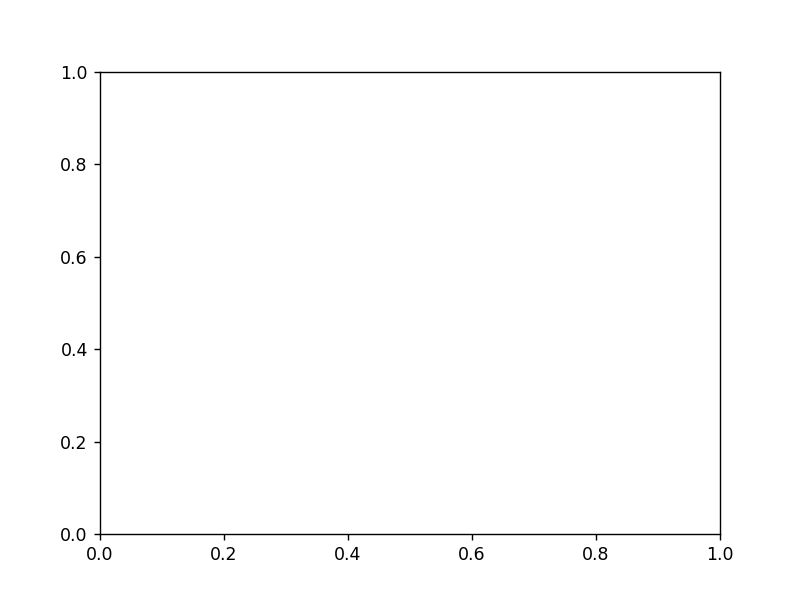

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(0, 1)

In [10]:
for i in range(0,1000):
    plt.scatter(i,i)
    plt.scatter(i,i+100)
    plt.scatter(i,i+2)

In [11]:
plt.cla()

In [17]:
from pathlib2 import Path
import numpy as np
import struct
FILE_INFO_BYTE_NUM = 1065
ENTITLE_SIZE = 90
def load_GPR_data(filepath, samplePoint=1024):
        dPosXYZs = []
        radarData = []
        try:
            file = Path(filepath)
            fileByte = file.stat().st_size
            print(fileByte)
            traceByte = 90 + samplePoint * 2
            traceNum = int((fileByte - FILE_INFO_BYTE_NUM) / traceByte)
            if isinstance(traceNum, int):
                with open(file, 'rb') as f:
                    f.seek(FILE_INFO_BYTE_NUM)
                    for ele in range(0, traceNum):
                        fGPSOffset = struct.unpack('f', f.read(4))[0]
                        chReserve = struct.unpack('2c', f.read(1 * 2))

                        ucYear = struct.unpack('B', f.read(1))[0]
                        ucMonth = struct.unpack('B', f.read(1))[0]
                        ucDay = struct.unpack('B', f.read(1))[0]
                        ucHour = struct.unpack('B', f.read(1))[0]
                        ucMin = struct.unpack('B', f.read(1))[0]
                        ucSec = struct.unpack('B', f.read(1))[0]
                        usMilSec = struct.unpack('H', f.read(2))[0]

                        dPosXYZ = struct.unpack('3d', f.read(8 * 3))
                        dPosXYZs.append(dPosXYZ)

                        ucTrcCount = struct.unpack('BB', f.read(1 * 2))
                        ucVoltage = struct.unpack('BB', f.read(1 * 2))

                        fWheelOffset = struct.unpack('f', f.read(4))[0]

                        chPhotoName1 = struct.unpack('8c', f.read(1 * 8))
                        chPhotoName2 = struct.unpack('8c', f.read(1 * 8))

                        usMetalDiameter = struct.unpack('H', f.read(2))[0]
                        usMetalDepth = struct.unpack('H', f.read(2))[0]
                        bMetalFlag = struct.unpack('?', f.read(1))[0]

                        chMarkName = struct.unpack('17c', f.read(1 * 17))
                        fMarkHeight = struct.unpack('f', f.read(4))[0]
                        usMarkFlag = struct.unpack('H', f.read(2))[0]

                        data = struct.unpack(str(samplePoint) + 'h', f.read(samplePoint * 2))
                        radarData.append(data)
                dPosXYZs = np.array(dPosXYZs).T
                return dPosXYZs, radarData
            else:
                return 2
        except Exception as e:
            print(e)
            return 3

In [18]:
gps, radar = load_GPR_data("E:/RadarCAS/data/2021_01_20_10_38_29.GPR")

21522173


01/22/2021 09:37:28 AM - INFO - mainFrame.py - start_calculate_action - 535 - Prior Calculate done..
GPR DATA LENGTH : 54896353
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
Start calculate==>Counter : 0 Current calculate index: 416
01/22/2021 09:38:36 AM - INFO - mainFrame.py - before_start_collection - 391 - Before starting thread...

In [20]:
len(radar[1900])

1024

(3, 10066)
